## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [60]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from random import sample 

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import json

import warnings

# Suppress FutureWarning related to sparse data types
warnings.filterwarnings("ignore", category=FutureWarning)


## Do some early processing of your metadata for easier model training:

In [61]:
PNEUMONIA_TAG = 'pneumonia'
NO_PNEUMONIA_TAG = 'no_pneumonia'
SAMPLE_LABELS = 'sample_labels.csv'
IMAGES_PATH= 'data/images_*/*.png'
EPOCHS = 50

In [62]:
def load_dataframe(filename, image_path_pattern):
    """
    Load a DataFrame from a CSV file and preprocess it for medical image classification.

    Args:
        filename (str): Path to the CSV file.
        image_path_pattern (str): Pattern for finding image files.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
        list: List of unique disease labels.
    """
    try:
        dataframe = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: The file {filename} does not exist.")
        return None, None

    all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/kaggle/input/data','images*', '*', '*.png'))}
    print('Scans found:', len(all_image_paths), ', Total Headers', dataframe.shape[0])
    dataframe['path'] = dataframe['Image Index'].map(all_image_paths.get)

    all_labels = np.unique(list(chain(*dataframe['Finding Labels'].map(lambda finding: finding.split('|')).tolist())))
    all_labels = [label for label in all_labels if len(label) > 0]

    for label in all_labels:
        dataframe[label] = dataframe['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

    dataframe['pneumonia_class'] = dataframe['Pneumonia'].replace(1, PNEUMONIA_TAG).replace(0, NO_PNEUMONIA_TAG)

    return dataframe, all_labels


In [63]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_xray_df, all_labels = load_dataframe(SAMPLE_LABELS, IMAGES_PATH)
all_xray_df.head()

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,1,0,1,no_pneumonia
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,no_pneumonia
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,no_pneumonia
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,no_pneumonia
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,no_pneumonia


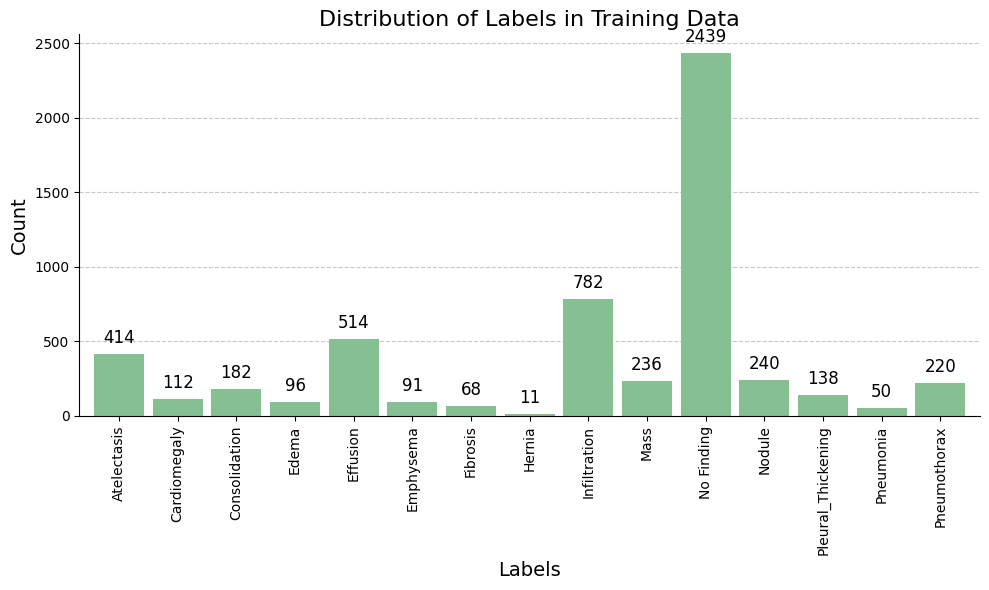

In [64]:
# Plot the bar chart
ax = train_df[all_labels].sum().plot(kind='bar', figsize=(10, 6), color='#86bf91', zorder=2, width=0.85)

# Add title and labels
plt.title("Distribution of Labels in Training Data", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Customize the grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()


## Create your training and testing data:

### We will
- Split the data into train(80%) and validation(20%) based on the pneumonia_class.
- Correct the balance of the train to 50 postive and 50 negative cases.
- Correct the balance in the validation set based on the presence pneumonia with a 80-20 split.

In [65]:
def create_splits(dataframe, class_weight_enabled=False):
    # 1. Split data into train and validation sets 80%-20%
    train_data, valid_data = train_test_split(dataframe, test_size=0.2, stratify=dataframe['pneumonia_class'])

    if class_weight_enabled:
        # Get the unique class labels present in your target variable
        unique_classes = train_data['pneumonia_class'].unique()
        
        # Ensure that the class labels are non-empty and represent all possible labels
        if len(unique_classes) == 0:
            raise ValueError("No unique class labels found in the target variable.")
        
        # Calculate class weights based on the imbalance in the training data
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_data['pneumonia_class'])

        # Assign class weights to the training data
        class_weight_dict = {label: weight for label, weight in zip(unique_classes, class_weights)}
    else:
        class_weight_dict = None

    # Return the training data, validation data, and class weight dictionary
    return train_data, valid_data, class_weight_dict

train_df, valid_df, class_weights = create_splits(all_xray_df, class_weight_enabled=True)


In [66]:
IMG_SIZE = (224,224)

In [67]:
def my_image_augmentation(rescale=1. / 255.0, horizontal_flip=True, vertical_flip=False,
                          height_shift_range=0.1, width_shift_range=0.1,
                          rotation_range=20, shear_range=0.1, zoom_range=0.1, custom_augmentation=None):
    """
    Create an ImageDataGenerator for data augmentation.

    Args:
        rescale (float): Rescaling factor for image pixel values.
        horizontal_flip (bool): Randomly flip images horizontally.
        vertical_flip (bool): Randomly flip images vertically.
        height_shift_range (float): Range for random vertical shifts.
        width_shift_range (float): Range for random horizontal shifts.
        rotation_range (int): Degree range for random rotations.
        shear_range (float): Shear intensity for random shearing.
        zoom_range (float): Range for random zooming.
        custom_augmentation (callable, optional): Custom augmentation function.

    Returns:
        ImageDataGenerator: Augmentation generator.
    """
    my_idg = ImageDataGenerator(
        rescale=rescale,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        height_shift_range=height_shift_range,
        width_shift_range=width_shift_range,
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
    )

    # Add custom augmentation if provided
    if custom_augmentation is not None:
        my_idg = custom_augmentation(my_idg)

    return my_idg

def make_train_gen(dataframe, img_size=(224, 224), batch_size=64, custom_augmentation=None):
    """
    Create a generator for training data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing image file paths and labels.
        img_size (tuple): Target image size (height, width).
        batch_size (int): Batch size for training.
        custom_augmentation (callable, optional): Custom augmentation function.

    Returns:
        DirectoryIterator: Training data generator.
    """
    train_idg = my_image_augmentation(custom_augmentation=custom_augmentation)
    train_gen = train_idg.flow_from_dataframe(
        dataframe=dataframe,
        directory=None,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=img_size,
        batch_size=batch_size
    )

    return train_gen

def make_val_gen(dataframe, img_size=(224, 224), batch_size=128):
    """
    Create a generator for validation data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing image file paths and labels.
        img_size (tuple): Target image size (height, width).
        batch_size (int): Batch size for validation.

    Returns:
        DirectoryIterator: Validation data generator.
    """
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(
        dataframe=dataframe,
        directory=None,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=img_size,
        batch_size=batch_size
    )

    return val_gen

def make_test_gen(dataframe, img_size=(224, 224), batch_size=128):
    """
    Create a generator for test data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing image file paths and labels.
        img_size (tuple): Target image size (height, width).
        batch_size (int): Batch size for testing.

    Returns:
        DirectoryIterator: Test data generator.
    """
    test_idg = ImageDataGenerator(rescale=1. / 255.0)
    test_gen = test_idg.flow_from_dataframe(
        dataframe=dataframe,
        directory=None,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=img_size,
        batch_size=batch_size
    )

    return test_gen


In [68]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(valid_df)
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

Found 4484 validated image filenames belonging to 2 classes.
Found 1122 validated image filenames belonging to 2 classes.


### View Augmented Images

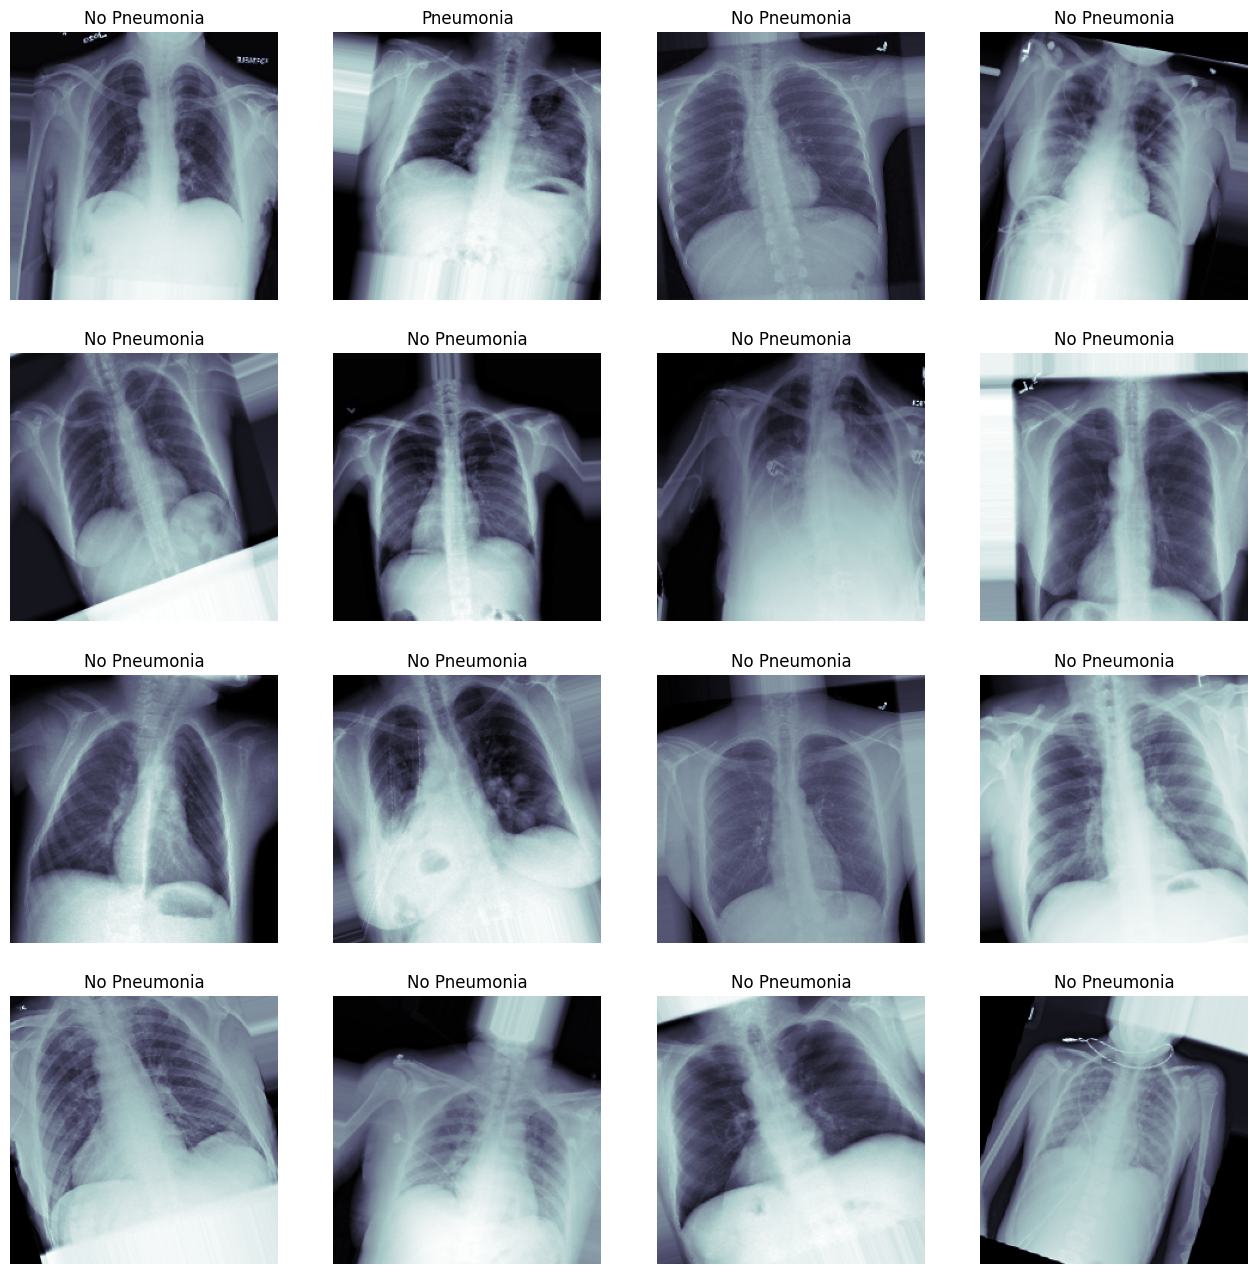

In [69]:

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

### Helper Functions 

In [70]:
# Define a custom color palette
custom_palette = ['#A8A7A7', '#CC527A', '#E8175D', '#474747', '#363636']

def plot_training_loss_accuracy(history):
    plt.figure(figsize=(16, 16))
    plt.subplot(2, 3, 1)
    plt.plot(history.history["loss"], label="Training Loss", color=custom_palette[0])
    plt.plot(history.history["val_loss"], label="Validation Loss", color=custom_palette[1])
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(history.history["binary_accuracy"], label="Training Accuracy", color=custom_palette[2])
    plt.plot(history.history["val_binary_accuracy"], label="Validation Accuracy", color=custom_palette[3])
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

def plot_auc_curve(t_y, p_y):
    fpr, tpr, _ = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)

    plt.subplot(2, 3, 3)
    plt.plot(fpr, tpr, color=custom_palette[0], lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color=custom_palette[1], linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")

def plot_precision_recall_curve(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    average_precision = average_precision_score(t_y, p_y)

    plt.subplot(2, 3, 4)
    plt.plot(recall, precision, color=custom_palette[2], lw=2, label="Precision-Recall curve (AP = %0.2f)" % average_precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

def plot_threshold_vs_f2_score(true_labels, predicted_probabilities):
    # Initialize variables to store F2 scores and thresholds
    f2_scores = []
    thresholds = np.arange(0.1, 1.0, 0.01)

    # Iterate over each threshold and calculate the F2 score
    for threshold in thresholds:
        # Convert predicted probabilities to binary predictions based on the threshold
        predicted_labels = (predicted_probabilities > threshold).astype(int)

        # Calculate the F2 score and append to the list
        f2 = fbeta_score(true_labels, predicted_labels, beta=2, average='binary')
        f2_scores.append(f2)

    # Find the threshold with the highest F2 score
    best_threshold = thresholds[np.argmax(f2_scores)]
    best_f2_score = max(f2_scores)

    # Plot the F2 scores vs. thresholds
    plt.subplot(2, 3, 5)
    plt.plot(thresholds, f2_scores, label='F2 Score', color='b')
    plt.scatter([best_threshold], [best_f2_score], color='r', label=f'Best Threshold = {best_threshold:.2f}\nBest F2 Score = {best_f2_score:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F2 Score')
    plt.title('F2 Score vs. Threshold')
    plt.legend()
    plt.grid(True)

def plot_confusion_matrix(true_labels, predicted_probabilities, best_threshold=0.5):
    # Convert predicted probabilities to binary predictions using the best threshold
    predicted_labels = (predicted_probabilities > best_threshold).astype(int)

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a heatmap for the confusion matrix with the custom color palette
    plt.subplot(2, 3, 6)
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette("Blues"), cbar=False, square=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')


# Now we can begin our model-building & training

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

### Traning and Model Evaluation 

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

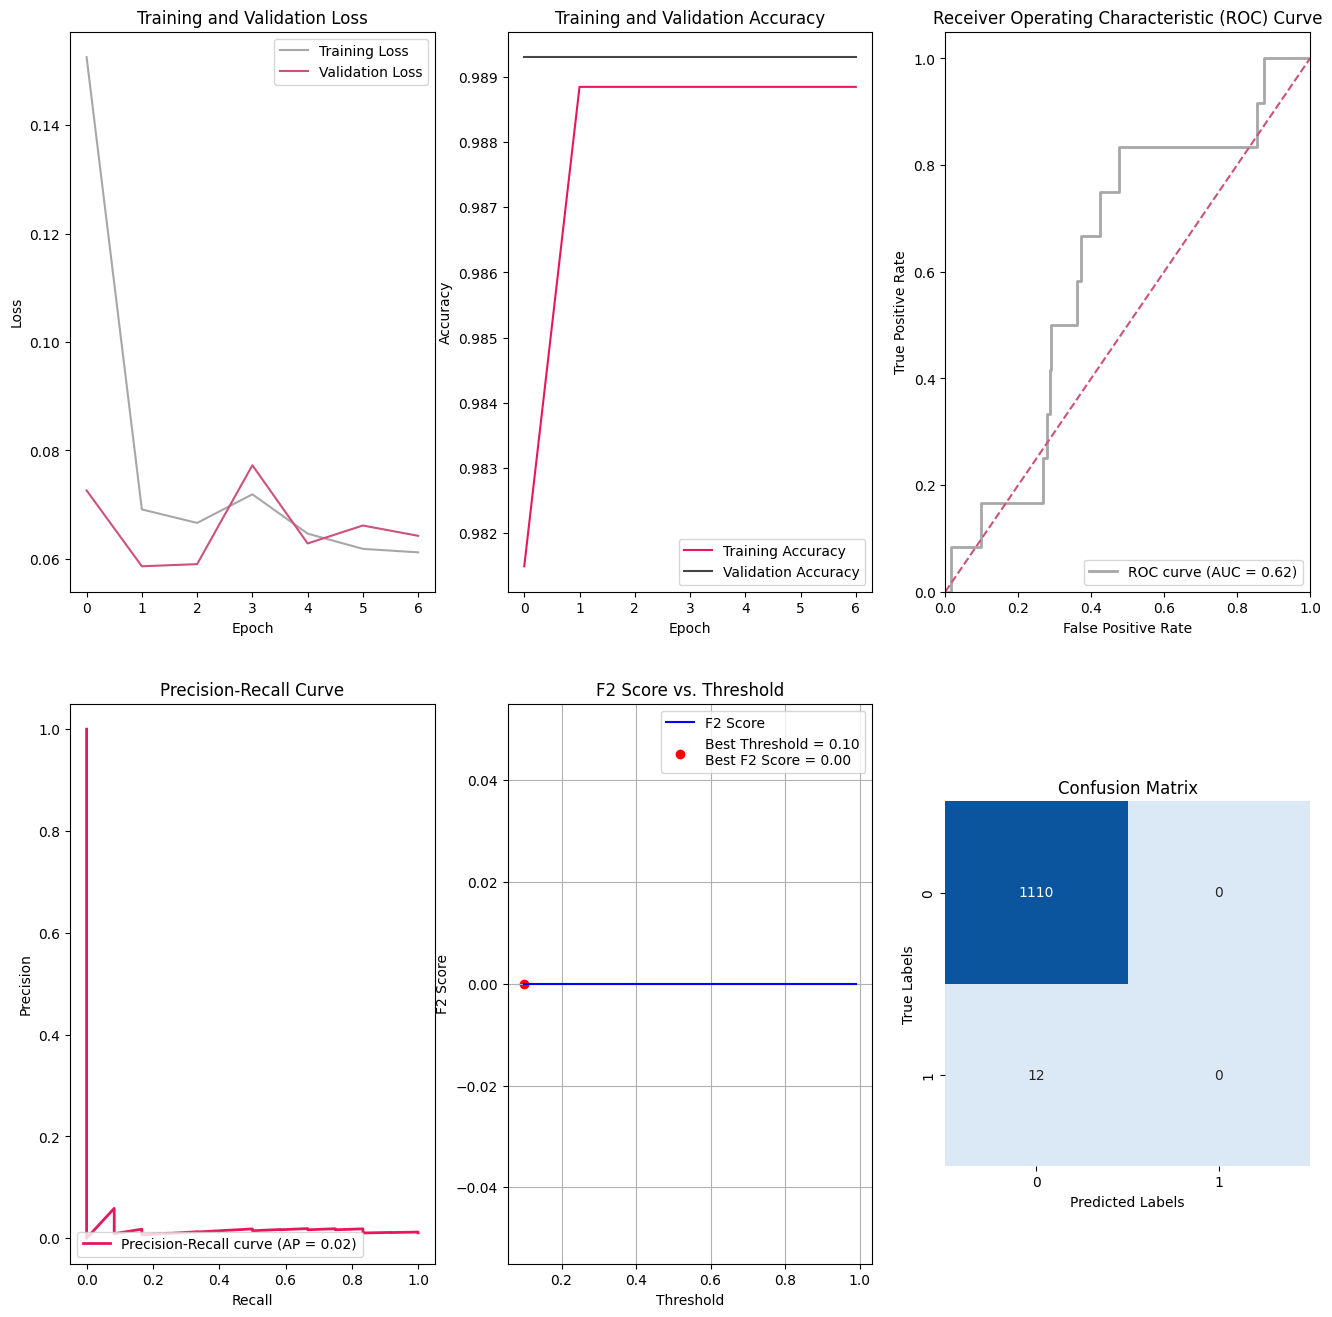

In [71]:
def load_pretrained_model(layer_of_interest, include_top=True, weights='imagenet'):
    # Load a pre-trained VGG16 model with customization options.
    base_model = VGG16(include_top=include_top, weights=weights)
    transfer_layer = base_model.get_layer(layer_of_interest)
    vgg_model = Model(inputs=base_model.input, outputs=transfer_layer.output)
    return vgg_model

def build_custom_model(base_model, num_classes, dropout_rate=0.2, dense_units=(1024, 512)):
    # Build a custom model on top of a pre-trained base model.
    custom_model = Sequential()
    custom_model.add(base_model)
    custom_model.add(Flatten())

    for units in dense_units:
        custom_model.add(Dense(units, activation='relu'))
        custom_model.add(Dropout(dropout_rate))

    custom_model.add(Dense(num_classes, activation='sigmoid'))
    return custom_model

def compile_model(model, learning_rate=1e-4, loss='binary_crossentropy', metrics=['binary_accuracy']):
    # Compile a custom model with specified optimizer, loss function, and metrics.
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def add_checkpoints_and_early_stopping(model_name, metric_to_monitor='val_loss', mode='min', patience=10):
    # Add checkpoints and early stopping to a model training process.
    weight_path = f"{model_name}_my_model.best.hdf5"
    checkpoint = ModelCheckpoint(
        weight_path,
        monitor=metric_to_monitor,
        verbose=1,
        save_best_only=True,
        mode=mode,
        save_weights_only=True
    )

    early = EarlyStopping(
        monitor=metric_to_monitor,
        mode=mode,
        patience=patience
    )

    callbacks_list = [checkpoint, early]
    return callbacks_list

def main():
    lay_of_interest = 'block5_pool'

    # Load a pre-trained VGG16 model
    vgg_model = load_pretrained_model(layer_of_interest=lay_of_interest)
    vgg_model.summary()

    # Freeze all layers except the last block
    for layer in vgg_model.layers[:-2]:
        layer.trainable = False

    # Print the layers to check their trainable status
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

    # Build your custom model on top of the pre-trained model
    num_classes = 1  # Change this to the number of output classes
    custom_model = build_custom_model(base_model=vgg_model, num_classes=num_classes)

    # Compile the custom model
    compiled_model = compile_model(model=custom_model, learning_rate=1e-3, loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Add checkpoints and early stopping
    callbacks_list = add_checkpoints_and_early_stopping(model_name='xray_class', metric_to_monitor='val_loss', mode='min', patience=5)

    # Train your model (replace train_gen and val_gen with your data generators)
    history = compiled_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks_list
    )
    
    # Save model architecture to a JSON file
    model_json = compiled_model.to_json()
    with open("my_model.json", "w") as json_file:
        json_file.write(model_json)

    # Load the trained weights into your model
    compiled_model.load_weights('xray_class_my_model.best.hdf5')

    # Make predictions (replace 'val_gen' with your data generator)
    pred_Y = compiled_model.predict(val_gen, batch_size=32, verbose=True)

    # Plot the charts
    plot_training_loss_accuracy(history)
    plot_auc_curve(val_gen.classes, pred_Y)
    plot_precision_recall_curve(val_gen.classes, pred_Y)
    # Add these lines to call the new functions
    plot_threshold_vs_f2_score(val_gen.classes, pred_Y)
    plot_confusion_matrix(val_gen.classes, pred_Y)
    plt.show()
    
    


main()


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project